In [1]:
import csv 
import pickle 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense
logging.set_verbosity(logging.ERROR)

## Load the Dataset 

In [2]:
# define path for the dataset 
file_path = './daily-min-temperatures.csv'

# Open and show first three rows of the data
with open(file_path, 'r') as file:
    print("Header looks like this:\n\n{}".format(file.readline()))    
    print("First data point looks like this:\n\n{}".format(file.readline()))
    print("Second data point looks like this:\n\n{}".format(file.readline()))

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



## Parsing the data

In [3]:
# Function to Plot the data into time series graph
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
# Function to parse the data and show it on time series graph
def parse_data_from_file(filename):
    
    # An empty list to store the temperatures and their times 
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        # read the file and split the data using commas 
        reader = csv.reader(csvfile, delimiter=',')
        
        # skip the header
        next(reader)

        # Assign the value of temperatures and times into lists
        for row in reader :
            temperatures.append(float(row[1]))
        for i in range(len(temperatures)):
            times.append(i)

    return times, temperatures

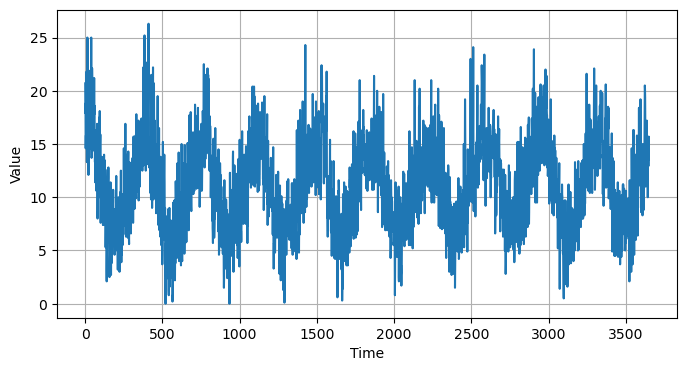

In [5]:
# Save the global variables within G Class
class G:
    file_path = './daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(file_path)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(8, 4))
plot_series(G.TIME, G.SERIES)
plt.show()

## Preprocessing the Data

This preprocessing phase, containts of two steps, Splitting the data into training and validation data and making windowed dataset 

In [6]:
# function to split the data, notice that the time_step argument is assigned with GLobal Variable Split Time
# which has value of 2500, meaning that 2500 data is used as training data, and 1000 data is used as validation data 
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [8]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE,shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Creating the Model Architecture 

In [9]:
def create_uncompiled_model():
    model = Sequential([
        Conv1D(filters=64,kernel_size=3,strides=1,activation='relu',padding='causal',input_shape=[G.WINDOW_SIZE,1]),
        LSTM(64, return_sequences= True),
        LSTM(64),
        Dense(30, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation='relu')
    ])

    return model 

### Test the compatibility of the model 

The cell bellow is used to check the compability of the model. Run the cell bellow if you are experimenting with your model. If you use provided model above, you don't need to run it. 

In [10]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 1s 730ms/step
Your current architecture is compatible with the windowed dataset! :)


### Learning Rate Adjustment 

before train the actual model, we need to get the best learning rate for training. We use this function bellow to get it. 

The best learning rate is already provided on the training cell. You can skip this cell bellow if you wan't use the provided learning rate

In [22]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum = 0.9)
    #optimizer = tf.keras.optimizers.Adam

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"])
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [23]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 6s 39ms/step - loss: 10.2632 - mae: 10.7622 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 3s 41ms/step - loss: 10.2632 - mae: 10.7622 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 3s 40ms/step - loss: 10.2632 - mae: 10.7622 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 4s 53ms/step - loss: 10.2632 - mae: 10.7622 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 4s 55ms/step - loss: 10.2632 - mae: 10.7622 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 5s 64ms/step - loss: 10.2632 - mae: 10.7622 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 5s 56ms/step - loss: 10.2632 - mae: 10.7622 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 5s 59ms/step - loss: 10.2632 - mae: 10.7622 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 5s 57ms/step - loss: 10.2632 - mae:

(0.0001, 10.0, 0.0, 10.0)

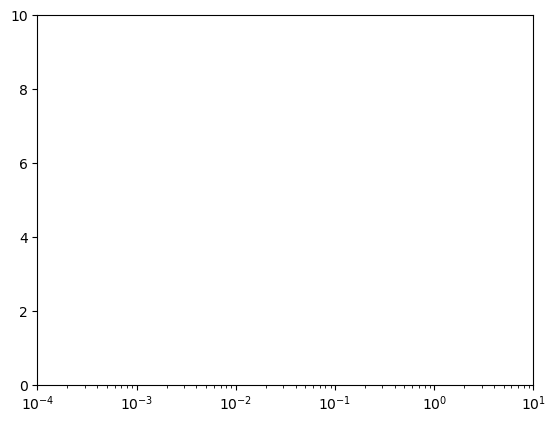

In [21]:
# show the learning rate history 
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

### Compile the model 

In [14]:
def create_model():
    
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3, momentum = 0.9),
                  metrics=["mae"])  

    return model

In [15]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 14s 86ms/step - loss: 5.8027 - mae: 6.2856
Epoch 2/50
77/77 [==============================] - 5s 66ms/step - loss: 2.0227 - mae: 2.4761
Epoch 3/50
77/77 [==============================] - 6s 69ms/step - loss: 1.8490 - mae: 2.3042
Epoch 4/50
77/77 [==============================] - 5s 68ms/step - loss: 1.7630 - mae: 2.2137
Epoch 5/50
77/77 [==============================] - 5s 64ms/step - loss: 1.7496 - mae: 2.2034
Epoch 6/50
77/77 [==============================] - 5s 69ms/step - loss: 1.6450 - mae: 2.0937
Epoch 7/50
77/77 [==============================] - 5s 65ms/step - loss: 1.6433 - mae: 2.0889
Epoch 8/50
77/77 [==============================] - 6s 70ms/step - loss: 1.6087 - mae: 2.0535
Epoch 9/50
77/77 [==============================] - 7s 84ms/step - loss: 1.6154 - mae: 2.0596
Epoch 10/50
77/77 [==============================] - 9s 108ms/step - loss: 1.5783 - mae: 2.0237
Epoch 11/50
77/77 [==============================] - 7s 8

In [16]:
model.save('forcastingModel.h5')

c:\Users\irsya\anaconda3\envs\tf\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluating and Forcasting 

This model using two evaluation metrics to evaluate the model's performace, which is mse and mae

In [17]:
# Function to Calculate the MSE and MAE
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [18]:
# Function to forecast the temperature using trained RNN Model 
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 [==============================] - 4s 28ms/step


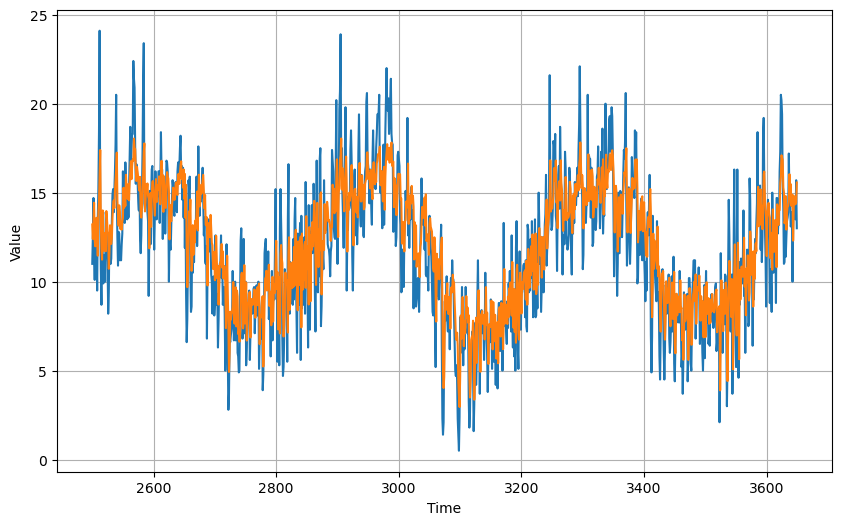

In [19]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.38, mae: 1.82 for forecast
